# thinking process

## completed:
1. simulated data come from another notebook I wrote, which involved domain knowledge referred from a coating paper
2. goal of this notebook is to explore bayesian optimization.

3. X array include machine parameters, ink properties values

4. y is reward, I want max(reward), idea from slot-die env reward design

5. I want to design the target function with quantile weight, inspired by quantle loss regression idea.

6. for slot die coating, two edge cases are: leaking, right: breaking-up

7. leakings are zero-tolerance defects. goal is to encourage more prediction points on right side

    R(x_u,x_f) = (x_f - x_u)*tao if x_u > half point;

           = (x_u - 0)*(1-tao) if x_u < half point
    
    interpretation : if tao = 0.1, then L will be larger for points located on left side, which potentially reach to leaking condition 
    Goal to Max R(f), so I will choose a larger tao, not only making x_u around center but also avoid optmization value getting to leaking condition

8. sampling for bayesian by changing ink property value

## wait to be completed:
9. test and validate on real machine 

# Bayesian structure designs
1. define the objective function that max rewards
    def objective(X_array):
        calculate process
        get x_estimate 
        return x_f - x_estimate
        
2. define domain space
    domain spaces include all input variables from ink property and machine setting parameters 
    it is a array (nRows,nFeatures)
 
3. define optimization algorithm
   
4. get result and visual -- future steps: hyperparameters tunning 

In [33]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
import math
from scipy.stats import norm
from scipy.optimize import minimize 
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [34]:
n_df = pd.read_csv("Newtonian_Simulation_V1.csv").iloc[:,1:]
n_df

,modified_CA,Newtonian_Stable,Xu_location(um),theta_angle,phi_angle,Web_speed(m/s),ink_viscosity(cP),coating_height(um),ratio,thickness(um),ambient_pressure(Pa)
0,0.105138,1,0.000406,120,60,0.05,16,200.0,1.5,133.333333,1.5125
1,0.105138,-1,0.000500,120,60,0.05,16,200.0,2.0,100.000000,1.5125
2,0.105138,-1,0.000557,120,60,0.05,16,200.0,2.5,80.000000,1.5125
3,0.105138,-1,0.000595,120,60,0.05,16,200.0,3.0,66.666667,1.5125
4,0.105138,-1,0.000622,120,60,0.05,16,200.0,3.5,57.142857,1.5125
...,...,...,...,...,...,...,...,...,...,...,...
94075,0.581283,-1,0.000525,160,120,0.65,60,500.0,3.0,166.666667,255.6125
94076,0.581283,-1,0.000532,160,120,0.65,60,500.0,3.5,142.857143,255.6125
94077,0.581283,-1,0.000538,160,120,0.65,60,500.0,4.0,125.000000,255.6125
94078,0.581283,-1,0.000542,160,120,0.65,60,500.0,4.5,111.111111,255.6125


In [2]:
# read data first 
# make X array and object function value 
nn_df = pd.read_csv("Non_Newtonian_Simulation_V1.csv").iloc[:,1:]
nn_df

,modified_CA,Non_Newtonian_Stable,Xu_location(um),theta_angle,phi_angle,Web_speed(m/s),ink_viscosity(cP),coating_height(um),ratio,thickness(um),ambient_pressure(Pa)
0,0.059062,0,-0.002970,120,60,0.05,16,200.0,1.5,133.333333,1.429375
1,0.059062,-1,0.000552,120,60,0.05,16,200.0,2.0,100.000000,1.429375
2,0.059062,-1,0.003242,120,60,0.05,16,200.0,2.5,80.000000,1.429375
3,0.059062,-1,0.004088,120,60,0.05,16,200.0,3.0,66.666667,1.429375
4,0.059062,-1,0.004601,120,60,0.05,16,200.0,3.5,57.142857,1.429375
...,...,...,...,...,...,...,...,...,...,...,...
94075,0.194801,-1,0.003857,160,120,0.65,60,500.0,3.0,166.666667,241.564375
94076,0.194801,-1,0.004375,160,120,0.65,60,500.0,3.5,142.857143,241.564375
94077,0.194801,-1,0.004735,160,120,0.65,60,500.0,4.0,125.000000,241.564375
94078,0.194801,-1,0.005003,160,120,0.65,60,500.0,4.5,111.111111,241.564375


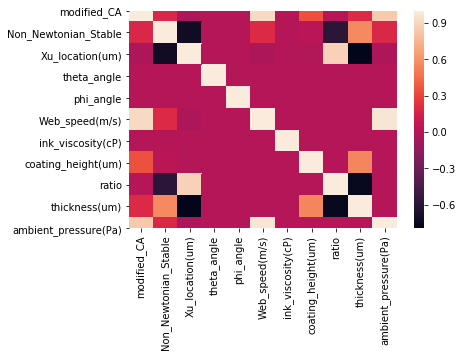

In [9]:
# some columns in nn_df have correlations, so I only select columns with no correlation based on domain knowledge
# correlation can also be detected by heat map
# five parameters : theta, phi, U, mu, g, r 

import seaborn as sns
corr = nn_df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [13]:
corr[(corr.abs()>0.7) & (corr.abs() < 1.0)]

,modified_CA,Non_Newtonian_Stable,Xu_location(um),theta_angle,phi_angle,Web_speed(m/s),ink_viscosity(cP),coating_height(um),ratio,thickness(um),ambient_pressure(Pa)
modified_CA,NaN,NaN,NaN,NaN,NaN,0.912389,NaN,NaN,NaN,NaN,0.839359
Non_Newtonian_Stable,NaN,NaN,-0.714527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Xu_location(um),NaN,-0.714527,NaN,NaN,NaN,NaN,NaN,NaN,0.874848,-0.792715,NaN
theta_angle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phi_angle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Web_speed(m/s),0.912389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.970725
ink_viscosity(cP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coating_height(um),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ratio,NaN,NaN,0.874848,NaN,NaN,NaN,NaN,NaN,NaN,-0.756802,NaN
thickness(um),NaN,NaN,-0.792715,NaN,NaN,NaN,NaN,NaN,-0.756802,NaN,NaN


In [3]:
input_list = ["theta_angle","phi_angle","Web_speed(m/s)","ink_viscosity(cP)","coating_height(um)","ratio"]
X_array_nn = nn_df[[*input_list]]
X_array_nn["coating_height(um)"] = X_array_nn["coating_height(um)"].apply(lambda x:x*1e-6)
X_array_nn.head()

,theta_angle,phi_angle,Web_speed(m/s),ink_viscosity(cP),coating_height(um),ratio
0,120,60,0.05,16,0.0002,1.5
1,120,60,0.05,16,0.0002,2.0
2,120,60,0.05,16,0.0002,2.5
3,120,60,0.05,16,0.0002,3.0
4,120,60,0.05,16,0.0002,3.5


In [35]:
# for newtonian
X_array_n = n_df[[*input_list]]
X_array_n["coating_height(um)"] = X_array_n["coating_height(um)"].apply(lambda x:x*1e-6)
X_array_n.head()

,theta_angle,phi_angle,Web_speed(m/s),ink_viscosity(cP),coating_height(um),ratio
0,120,60,0.05,16,0.0002,1.5
1,120,60,0.05,16,0.0002,2.0
2,120,60,0.05,16,0.0002,2.5
3,120,60,0.05,16,0.0002,3.0
4,120,60,0.05,16,0.0002,3.5


# Notes
1. surrogate: posterior 
2. acquisition: Sampling involves careful use of the posterior i: usually EI

posterior = likelihood * prior
(conditional prob) = (reverse of conditional prob) * marginal prob

The posterior represents everything we know about the objective function. It is an approximation of the objective function and can be used to estimate the cost of different candidate samples that we may want to evaluate.

so, the posterior probability is a surrogate objective function. In this notebook, I used Gaussian process

surrogate = P(D|f) * object function

P(f|D) = P(D|f) * P(f)

1. Select a Sample by Optimizing the Acquisition Function.
2. Evaluate the Sample With the Objective Function.
3. Update the Data and, in turn, the Surrogate Function.
4. Go To 1.

## functions and their roles:
1. object fc : input is X_array, output here is loss calculation
2. surrogate fc: surrogate for the object function : gussian.predict 
3. acquisition: get best surrogate score (here is EI) from surrogate function
4. optimize for acquisition is np.min(- EI)


In [ ]:
# surrogate: use GaussianProcessRegressor
# acquisition: EI (do more research later)
# new samples: use ideas from RL env to generate new samples 

In [36]:
# newtonian list
property_list_newtonian = [1,0.045,0.066,1210]
x_f = 0.0005
x_d = 0.101
h_w = 0.1
quantile = 0.5

In [26]:
# non_newtonian list 
property_list = [0.53,0.25,0.065,1143.5]
x_f = 0.0005
x_d = 0.101
h_w = 0.1
quantile = 0.5

In [28]:
def objective(x_input,ink_value=property_list,judge = x_f, qt = quantile,Xd =x_d):
    """
    objective function to max rewards 
    
    design this function with quantile weight, inspired by quantle loss regression idea and rewards matrix used in the RL notebook

    for slot die coating, two edge cases are: leaking, right: breaking-up

    leakings are zero-tolerance defects. goal is to encourage more prediction points on right side

    R(x_u,x_f) = (x_f - x_u)*tao if x_u - half point > 0;

               = (x_u - 0)*(1-tao) if x_u - half point < 0 
    
    interpretation : if tao = 0.1, then R will be larger for points located on left side, which potentially increase chance to make x_u on left part of middle point
    goal is to max rewards 
   
    """
    # get output from input, input is a matrix with 6 columns
    # get ink properties:
    n,m,sigma,density = ink_value
    y = []
    for x_i in x_input: 
    # searching values and doing calculations
        
        theta, phi, U, mu, g, r = x_i  
        # delete theta, phi, mu. only keep U g r. In addition, add error range for fr
        thickness = g/r  
        fr = thickness*(U*h_w)
            
        a = (U*(n+1)*(2*n+1)/n)**n*(g**(-n-1))
        b_s = (U*(g-2*thickness)*(n+1)*(2*n+1)/n)**n * (g**(-2*n-1))
        b_l = -(U*(2*thickness-g)*(n+1)*(2*n+1)/n)**n * (g**(-2*n-1))
        modified_CA = ((U*m*(U/g)**(n-1))/sigma)**(2/3)      
        p_ambient = density*U**2/2

        if thickness <= g/2:
            xu_estimate = judge - (p_ambient - 1.34*modified_CA*sigma/thickness - (Xd-judge)*m*b_s - sigma*(math.cos(theta)+math.cos(phi)))/a*m
                
        elif thickness > g/2:
            xu_estimate = judge - (p_ambient - 1.34*modified_CA*sigma/thickness - (Xd-judge)*m*b_l - sigma*(math.cos(theta)+math.cos(phi)))/a*m
        
        if xu_estimate <= 0:
            y.append(xu_estimate*2)
        elif xu_estimate >= judge/2 and xu_estimate < judge:
            y.append((judge - xu_estimate)*qt)
        elif xu_estimate < judge/2 and xu_estimate > 0:
            y.append(xu_estimate*(1-qt))
        else:
            y.append(-xu_estimate*2)
    
    return  y 
        

In [37]:
def objective_newtonian(x_input,ink_value=property_list_newtonian,judge = x_f, qt = quantile,Xd =x_d):
    """
    objective function to max rewards 
    
    for newtonian liquid, same ideas as objective funtion for non_newtonian but different formulas  
   
    """
    # get output from input, input is a matrix with 6 columns
    # get ink properties:
    n,m,sigma,density = ink_value
    y = []
#     est_x = []
    for x_i in x_input: 
    # searching values and doing calculations
        
        theta, phi, U, mu, g, r = x_i
        thickness = g/r  
        fr = thickness*(U*h_w)
            
        a = (U*(n+1)*(2*n+1)/n)**n*(g**(-n-1))
        b_s = (U*(g-2*thickness)*(n+1)*(2*n+1)/n)**n * (g**(-2*n-1))
        b_l = -(U*(2*thickness-g)*(n+1)*(2*n+1)/n)**n * (g**(-2*n-1))
        modified_CA = ((U*m*(U/g)**(n-1))/sigma)**(2/3)      
        p_ambient = density*U**2/2  ## need to look at more

        if thickness <= g/2:
            xu_estimate = judge - g**2*(p_ambient - 1.34*modified_CA*sigma/thickness - (Xd-judge)*m*b_s - sigma*(math.cos(theta)+math.cos(phi))/g)/(6*mu*U)
                     
        elif thickness > g/2:
            xu_estimate = judge - g**2*(p_ambient - 1.34*modified_CA*sigma/thickness - (Xd-judge)*m*b_l - sigma*(math.cos(theta)+math.cos(phi))/g)/(6*mu*U)
                
        
        if xu_estimate <= 0:
            y.append(xu_estimate*2)
        elif xu_estimate >= judge/2 and xu_estimate < judge:
            y.append((judge - xu_estimate)*qt)
        elif xu_estimate < judge/2 and xu_estimate > 0:
            y.append(xu_estimate*(1-qt))
        else:
            y.append(-xu_estimate*2)
    
    return  y

In [232]:
# test part for objective
retur_y = objective(X_array_nn.values)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


In [233]:
# see the est results compared to est1
check_table = pd.DataFrame({'object_reward':retur_y,'x_u':nn_df["Xu_location(um)"]})
check_table.head()

,object_reward,x_u
0,-0.005940,-0.002970
1,-0.001104,0.000552
2,-0.006484,0.003242
3,-0.008176,0.004088
4,-0.009202,0.004601


# ideas
don't think it is a strong metric, maybe because of data input limitation
double check with it later

In [253]:
reward_df = check_table[check_table["object_reward"]>0]
reward_df.sort_values(by=['object_reward'],ascending=False)

,object_reward,x_u
79401,9.445447e-05,0.000311
79457,9.445447e-05,0.000311
79905,9.445447e-05,0.000311
79849,9.445447e-05,0.000311
79793,9.445447e-05,0.000311
...,...,...
11673,1.140096e-07,0.000500
11729,1.140096e-07,0.000500
11785,1.140096e-07,0.000500
11841,1.140096e-07,0.000500


In [38]:
class Bayesian_opt():
    def __init__(self, target_func, x_init, y_init, n_iter, batch_size):
        # initial values
        self.x_init = x_init
        self.y_init = y_init
        self.n_iter = n_iter
        self.target_func = target_func
        self.batch_size = batch_size  
        
        self.best_samples = pd.DataFrame(columns = (input_list + ["y","ei"]))
        self.gauss_pr = GaussianProcessRegressor()
        self.distances_ = []
    # surrogate function using EI method, as a starting point  
    def _get_expected_improvement(self, x_new): 
        # do more research on different methods and figure out why choose EI
        # Using estimate from Gaussian surrogate instead of actual function for a new trial data point to avoid cost 
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new < 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for entire prior distribution to avoid cost
        # add a very small to avoid divide by zero sigma 
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)
        z = (mean_y_new - max_mean_y) / (sigma_y_new+1e-9)
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        
        return exp_imp
    
    def acquisition_function(self,x):
        # max (function) = min (-function)
        return -self._get_expected_improvement(x)
    
    def random_select_inputs(self):
        theta = np.random.choice(np.arange(120,140),self.batch_size)  # 10 扩大范围 看看有没有奇怪的suggestion
        phi = np.random.choice(np.arange(60,80),self.batch_size)  # 100 需要有一个相互依靠的关系
        # start with less points and larger iterations
        U = np.random.uniform(low = 0.05, high = 0.5, size = self.batch_size)
        mu = np.random.choice(np.arange(16,60),self.batch_size)
        g = np.random.choice(np.arange(250,500)*1e-6,self.batch_size)
        r = np.random.uniform(low = 1.5, high = 4, size = self.batch_size)
        random_matrix = np.stack([theta, phi, U, mu, g, r], axis=1)
        return random_matrix

    def _get_next_probable_point(self):
            min_ei = float(sys.maxsize)
            x_optimal = None 
            bounds = [(1e-6, 141), (1e-6, 81), (1e-6, 0.51), (1e-6, 60), (1e-6, 500*1e-6), (1e-6, 4.1)]
            # Trial with an array of input_simulated_data
            random_matrix = self.random_select_inputs()
            for x_start in random_matrix:
                response = minimize(fun=self.acquisition_function, x0=x_start, method='L-BFGS-B',bounds = bounds)
                if response.fun < min_ei:
                    min_ei = response.fun
                    x_optimal = response.x
            
            return x_optimal, min_ei  
        
    # wait for debug for rest of two functions     
    def _extend_prior_with_posterior_data(self, x,y):
        
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array([y]), axis = 0)
  
    def optimize(self):
        y_max_ind = np.argmax(self.y_init)
        y_max = self.y_init[y_max_ind]
        optimal_x = self.x_init[y_max_ind]
        optimal_ei = None
        for i in range(self.n_iter):
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array([x_next]))[0]
            self._extend_prior_with_posterior_data(x_next,y_next)
            # 
            if y_next > y_max:
                y_max = y_next
                optimal_x = x_next
                optimal_ei = ei

            if i == 0:
                 prev_x = x_next
            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
            
            self.best_samples = self.best_samples.append({"theta_angle":optimal_x[0],"phi_angle":optimal_x[1],"Web_speed(m/s)":optimal_x[2],
                                                           "ink_viscosity(cP)":optimal_x[3],"coating_height(um)":optimal_x[4],
                                                           "ratio":optimal_x[5],"y": y_max, "ei": optimal_ei},ignore_index=True)
        
        return optimal_x, y_max 
    

In [39]:
# newtonian
X_array_n_samples = X_array_n.sample(n=600,replace=False)
init_X = X_array_n_samples.values
init_Y = objective(init_X)

In [40]:
# bayesian for newtonian
bopt_newtonian = Bayesian_opt(target_func=objective_newtonian, 
                    x_init=init_X, 
                    y_init=init_Y, 
                    n_iter=100, 
                    batch_size=30)
bopt_newtonian.optimize()

(array([1.30000000e+02, 7.00000000e+01, 4.11161086e-01, 2.10000000e+01,
        3.52000000e-04, 1.51649383e+00]), 3.4198824156581346e-05)

In [41]:
bopt_newtonian.best_samples

,theta_angle,phi_angle,Web_speed(m/s),ink_viscosity(cP),coating_height(um),ratio,y,ei
0,130.0,120.0,0.550000,48.0,0.000500,1.500000,0.000034,NaN
1,130.0,120.0,0.550000,48.0,0.000500,1.500000,0.000034,NaN
2,130.0,120.0,0.550000,48.0,0.000500,1.500000,0.000034,NaN
3,130.0,120.0,0.550000,48.0,0.000500,1.500000,0.000034,NaN
4,130.0,120.0,0.550000,48.0,0.000500,1.500000,0.000034,NaN
...,...,...,...,...,...,...,...,...
95,130.0,70.0,0.411161,21.0,0.000352,1.516494,0.000034,[[-0.3989252823785525]]
96,130.0,70.0,0.411161,21.0,0.000352,1.516494,0.000034,[[-0.3989252823785525]]
97,130.0,70.0,0.411161,21.0,0.000352,1.516494,0.000034,[[-0.3989252823785525]]
98,130.0,70.0,0.411161,21.0,0.000352,1.516494,0.000034,[[-0.3989252823785525]]


In [48]:
max(init_Y)

3.399547337267167e-05

In [49]:
init_X[np.argmax(init_Y)]

array([1.3e+02, 1.2e+02, 5.5e-01, 4.8e+01, 5.0e-04, 1.5e+00])

In [8]:
# test bayesian for non_newtonian
# get x_init and y_init

X_array_nn_samples = X_array_nn.sample(n=600,replace=False)
init_X = X_array_nn_samples.values
init_Y = objective(init_X)

In [9]:
bopt = Bayesian_opt(target_func=objective, 
                    x_init=init_X, 
                    y_init=init_Y, 
                    n_iter=100, 
                    batch_size=30)
bopt.optimize()

(array([1.23000000e+02, 6.60000000e+01, 1.52163357e-01, 3.40000000e+01,
        4.71000000e-04, 1.99191590e+00]), 0.00011122632573969265)

In [42]:
max(init_Y)

3.399547337267167e-05

In [43]:
init_X[np.argmax(init_Y)]

array([1.3e+02, 1.2e+02, 5.5e-01, 4.8e+01, 5.0e-04, 1.5e+00])

In [10]:
bopt.best_samples

,theta_angle,phi_angle,Web_speed(m/s),ink_viscosity(cP),coating_height(um),ratio,y,ei
0,140.0,60.0,0.650000,28.0,0.000500,2.000000,0.000094,NaN
1,140.0,60.0,0.650000,28.0,0.000500,2.000000,0.000094,NaN
2,140.0,60.0,0.650000,28.0,0.000500,2.000000,0.000094,NaN
3,140.0,60.0,0.650000,28.0,0.000500,2.000000,0.000094,NaN
4,140.0,60.0,0.650000,28.0,0.000500,2.000000,0.000094,NaN
...,...,...,...,...,...,...,...,...
95,123.0,66.0,0.152163,34.0,0.000471,1.991916,0.000111,[[-0.3988950686811175]]
96,123.0,66.0,0.152163,34.0,0.000471,1.991916,0.000111,[[-0.3988950686811175]]
97,123.0,66.0,0.152163,34.0,0.000471,1.991916,0.000111,[[-0.3988950686811175]]
98,123.0,66.0,0.152163,34.0,0.000471,1.991916,0.000111,[[-0.3988950686811175]]


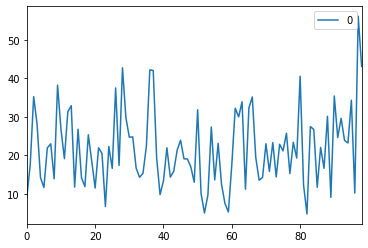

In [19]:
pd.DataFrame(bopt.distances_).plot()

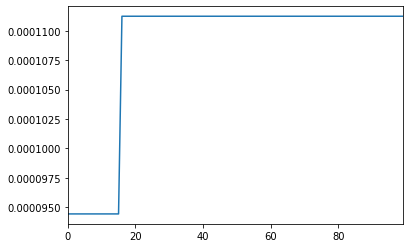

In [20]:
bopt.best_samples['y'].plot()

In [21]:
bopt.x_init.shape

(700, 6)

In [22]:
init_X.shape # adding more iteration 

(600, 6)